In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
!pip install tensorflow pandas numpy scikit-learn

Epoch 1/10
808/808 [==============================] - 5s 3ms/step - loss: nan
Epoch 2/10
808/808 [==============================] - 2s 3ms/step - loss: nan
Epoch 3/10
808/808 [==============================] - 3s 4ms/step - loss: nan
Epoch 4/10
808/808 [==============================] - 3s 4ms/step - loss: nan
Epoch 5/10
808/808 [==============================] - 2s 3ms/step - loss: nan
Epoch 6/10
808/808 [==============================] - 2s 3ms/step - loss: nan
Epoch 7/10
808/808 [==============================] - 2s 3ms/step - loss: nan
Epoch 8/10
808/808 [==============================] - 3s 4ms/step - loss: nan
Epoch 9/10
808/808 [==============================] - 3s 4ms/step - loss: nan
Epoch 10/10
202/202 [==============================] - 0s 2ms/step
NaN values in test_predict:
[nan nan nan ... nan nan nan]


<ipython-input-6-264a39ec9223>:74: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(test_predict)


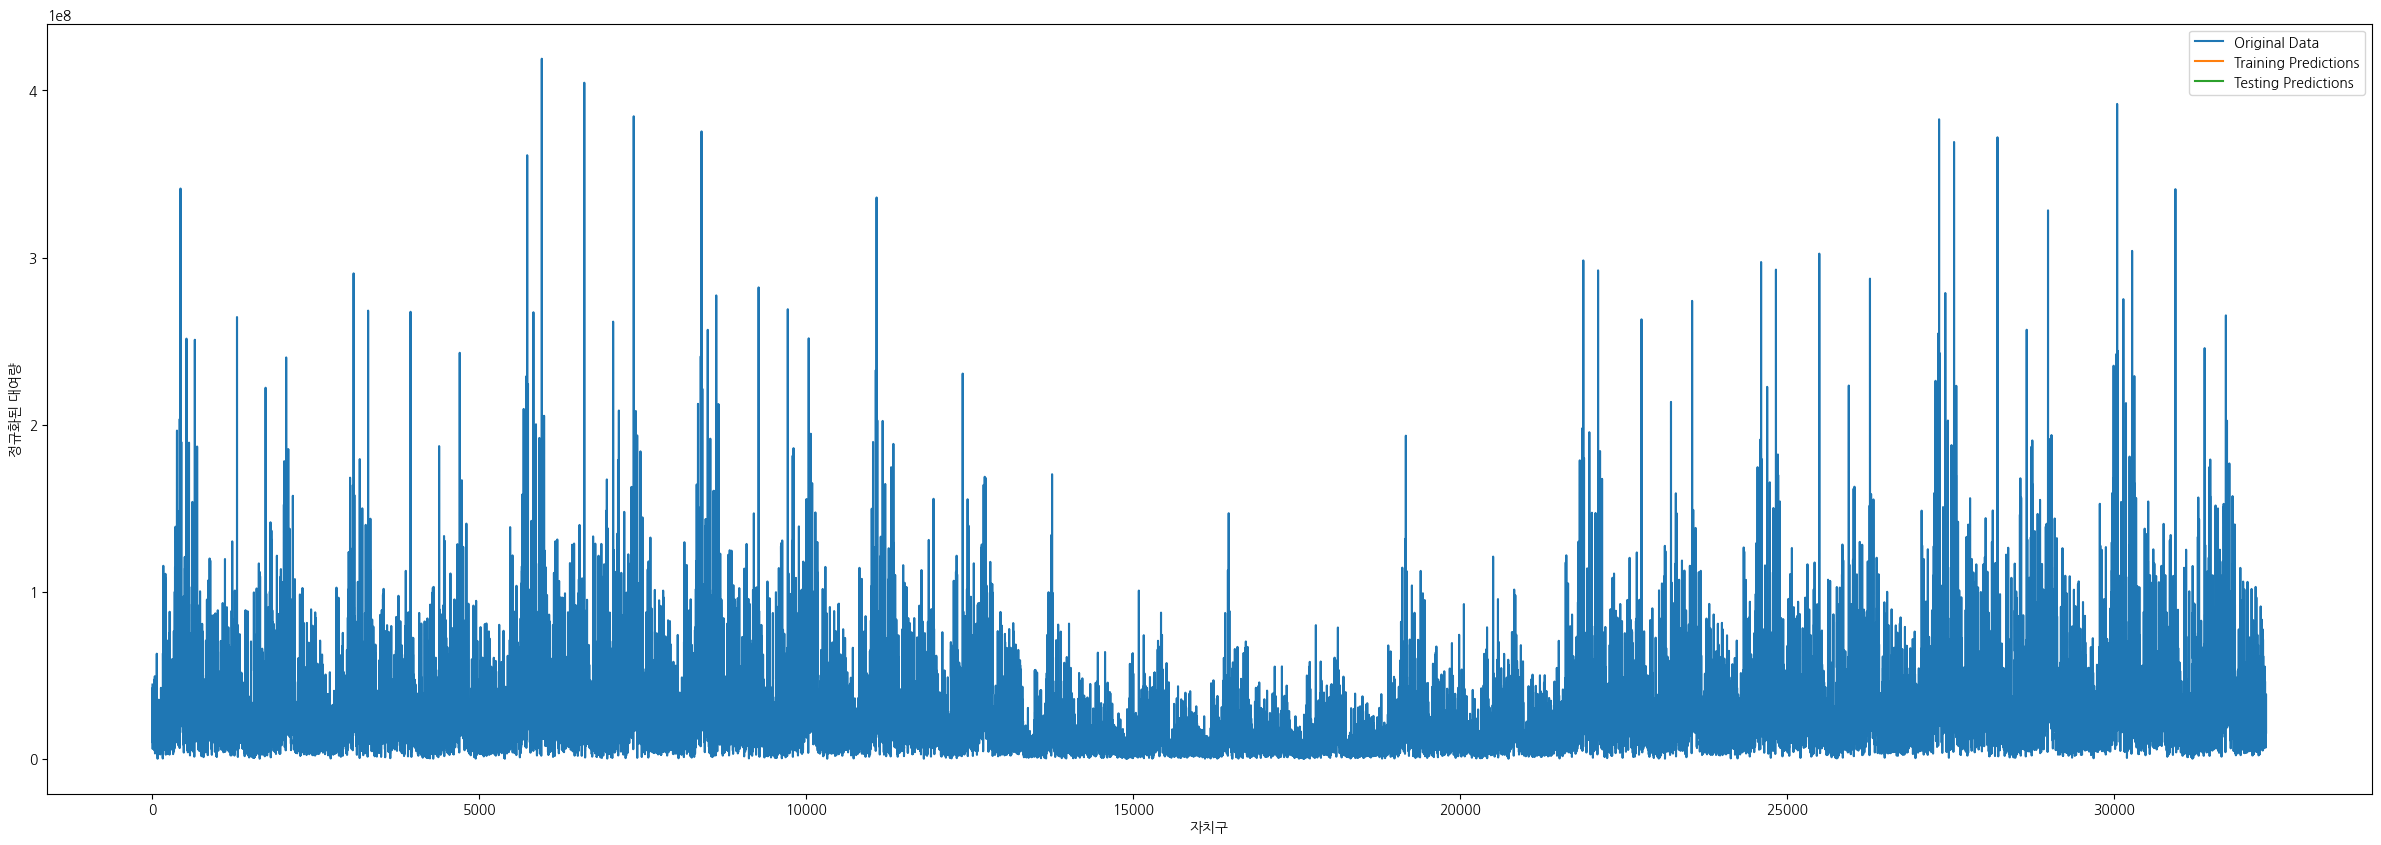

In [6]:
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 시계열 데이터를 입력으로 받아 LSTM 모델에 맞는 형태로 변환하는 함수
def create_dataset(dataset, time_steps=1):
    data_X, data_y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_y)

# 데이터 불러오기
df = pd.read_csv('대여소별_따릉이_이용데이터.csv')
df = df.fillna(0)

# 대여건수 및 반납건수의 숫자 추출 후 숫자로 변환
df['대여건수'] = pd.to_numeric(df['대여건수'].str.replace(',', ''), errors='coerce')
df['반납건수'] = pd.to_numeric(df['반납건수'].str.replace(',', ''), errors='coerce')

# '대여건수' 열 선택
data = df[['대여건수']].values.astype(float)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# 훈련 및 테스트 세트 분리
train_size = int(len(data_normalized) * 0.8)
train, test = data_normalized[0:train_size, :], data_normalized[train_size:len(data_normalized), :]

# 데이터셋 생성
time_steps = 10
X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, time_steps), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), y_train, epochs=10, batch_size=32)

# 예측
train_predict = model.predict(np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])))
test_predict = model.predict(np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])))


# 예측 결과를 정규화된 형태에서 되돌리기
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# 훈련 및 테스트 세트의 MSE 계산
#print('Train Mean Squared Error:', mean_squared_error(y_train[0], train_predict[:, 0]))
#print('Test Mean Squared Error:', mean_squared_error(y_test[0], test_predict[:, 0]))

# NaN 값 확인
nan_indices = np.isnan(test_predict)
if np.any(nan_indices):
    print("NaN values in test_predict:")
    print(test_predict[nan_indices])

# NaN 값을 평균값으로 대체
mean_value = np.nanmean(test_predict)
test_predict[nan_indices] = mean_value

# 예측 시각화
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_steps:len(train_predict) + time_steps, :] = train_predict

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_steps * 2):len(train_predict) + (time_steps * 2) + len(test_predict), :] = test_predict

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(30, 10))
plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Testing Predictions')
plt.xlabel('자치구')
plt.ylabel('정규화된 대여량')
plt.legend()
plt.show()
